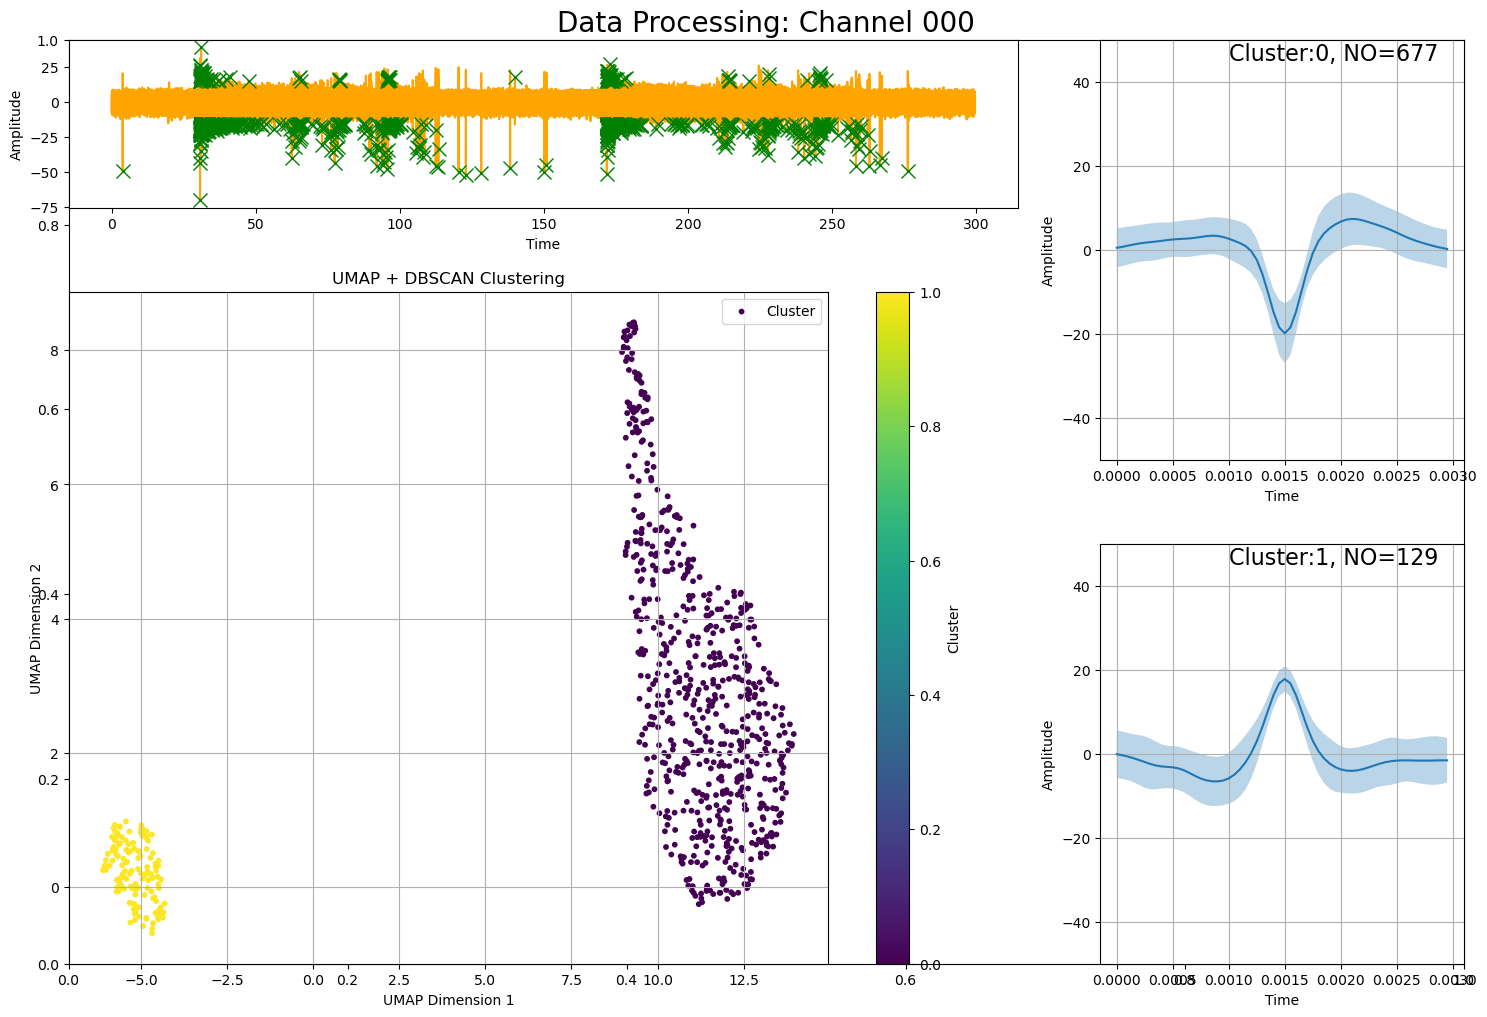

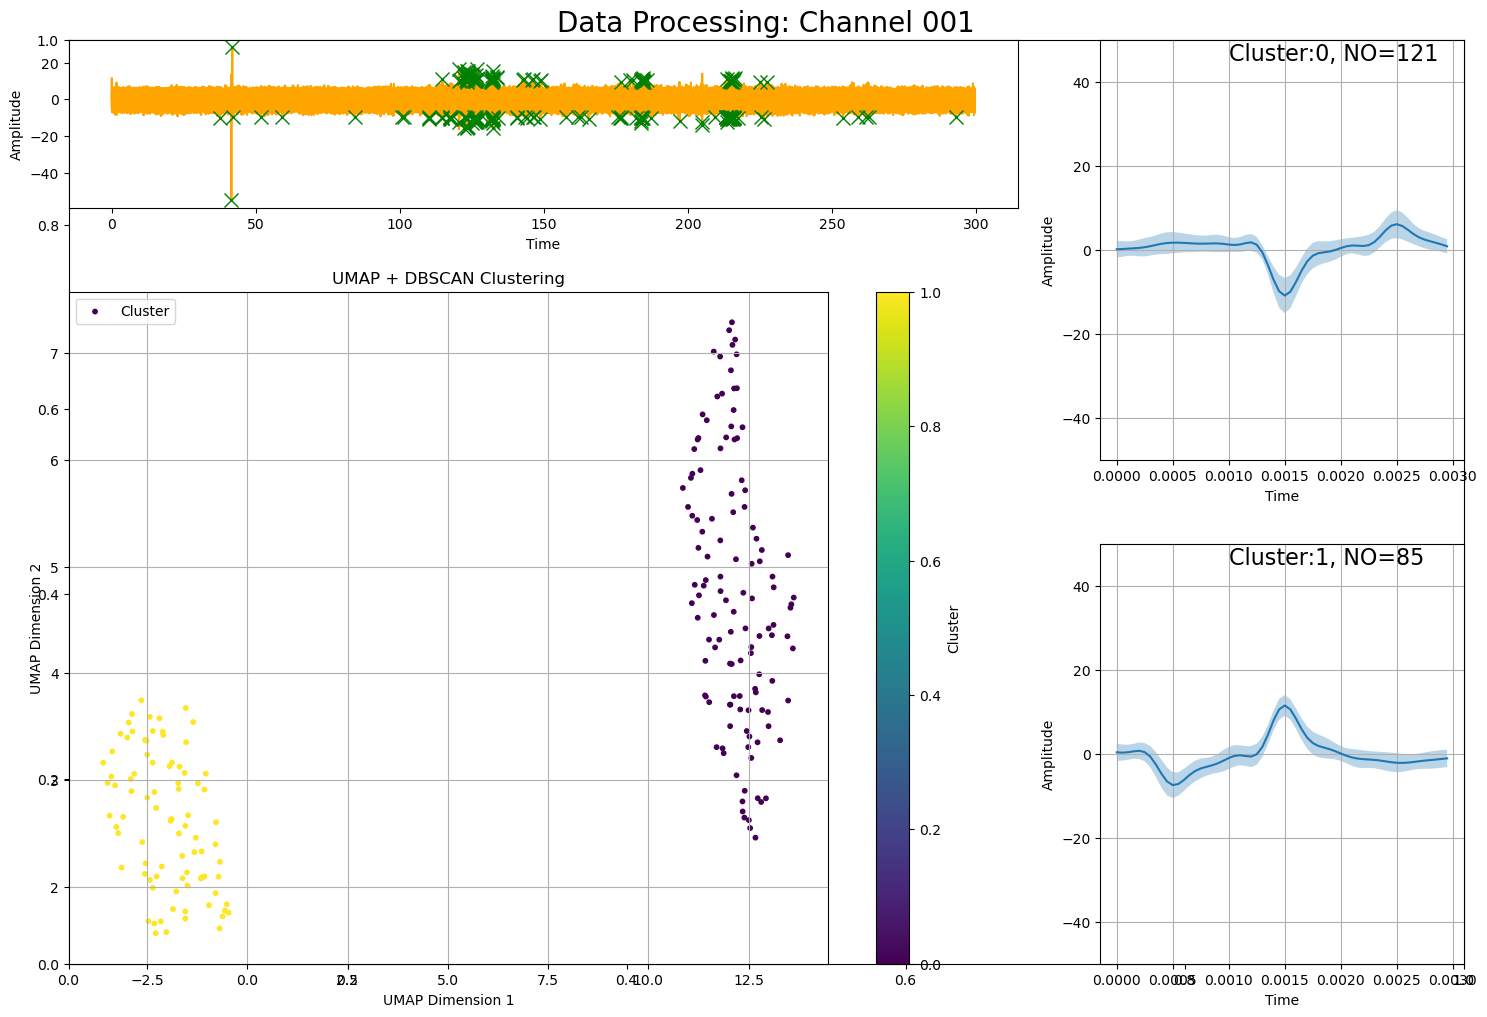

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import umap
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.cluster import DBSCAN
import csv
import os
import h5py

Export_FolderName = 'DataAnalysis'

with h5py.File(Export_FolderName + "/t.h5", 'r') as hdf:
    t = hdf['t'][:]
with h5py.File(Export_FolderName + "/example_data.h5", 'r') as hdf:
    amplifier_data = hdf['example_data'][:]


# ------------------------------------------------------------------------------
# ----------paratemers for data processing, make changes here-------------------
# ------------------------------------------------------------------------------
# parameters for filtering. 
order = 3                   
low_cutoff = 250           
high_cutoff = 3000    
    
# parameters for peak detection
baseline_width = 5      
peak_gap = 50           
min_peak_quantity = 30    
peak_amplitude_limit = 150 

#parameters for sorting
peak_width = 0.003       

#for UMAP
n_neighbors = 15     
min_dist = 0.1       
n_components = 2    

#for DBSCAN
eps = 0.5                   
min_sample = 5    


total_time = t[len(t)-1]
total_channel, total_data_point = amplifier_data.shape
sampling_rate = int(round(total_data_point / total_time))

all_filtered_data = np.zeros((total_channel, total_data_point)) 
all_peak_positions = []     
all_peak_datapoint = []     
all_peak_segments = []      
all_clusters = []         
all_units = []             

# --------------------------detect peaks---------------------------
window_size = int(peak_width / 2 * sampling_rate)
nyquist_freq = 0.5 * sampling_rate
low = low_cutoff / nyquist_freq
high = high_cutoff / nyquist_freq

b, a = butter(order, [low, high], btype='band')
for i in range(total_channel):
    processing_channel = amplifier_data[i]
    filtered_data = filtfilt(b, a, processing_channel) 
    threshold = baseline_width * np.std(filtered_data)
    
    all_filtered_data[i,:] = filtered_data  

    positive_peaks, _ = find_peaks(filtered_data, height=(threshold, peak_amplitude_limit), distance=peak_gap)
    negative_peaks, _ = find_peaks(-filtered_data, height=(threshold, peak_amplitude_limit), distance=peak_gap)

    # Filter out overlapping triphasic peaks
    keep_positive = np.ones(len(positive_peaks), dtype=bool)
    keep_negative = np.ones(len(negative_peaks), dtype=bool)
    for j, neg_idx in enumerate(negative_peaks):
        in_range_mask = np.abs(positive_peaks - neg_idx) <= peak_gap
        close_pos_indices = np.where(in_range_mask)[0]
        for k in close_pos_indices:
            pos_idx = positive_peaks[k]
            # Compare absolute amplitudes
            amp_neg = abs(filtered_data[neg_idx])
            amp_pos = filtered_data[pos_idx]
            if amp_neg > amp_pos:
                keep_positive[k] = False  
            else:
                keep_negative[j] = False 

    positive_peaks_filtered = positive_peaks[keep_positive]
    negative_peaks_filtered = negative_peaks[keep_negative]

    peak_position = np.concatenate((positive_peaks_filtered, negative_peaks_filtered)) 
    peak_datapoint_sorted = np.sort(peak_position) 
    
    # remove peaks that are too colose to the start and end of recording period
    peak_datapoint_sorted = [x for x in peak_datapoint_sorted if window_size <= x <= len(filtered_data)-window_size]
    peak_position_sorted = t[peak_datapoint_sorted]
    peak_windows = np.zeros((len(peak_datapoint_sorted), 2 * window_size))
    
    # devide all peaks into segments and store them
    for j, peak in enumerate(peak_datapoint_sorted):
        start_index = max(0, peak - window_size)
        end_index = min(len(filtered_data), peak + window_size)
        peak_window = filtered_data[start_index:end_index]  
        peak_windows[j, :] = peak_window
    
    all_peak_segments.append(peak_windows)
    all_peak_datapoint.append(peak_datapoint_sorted)
    all_peak_positions.append(peak_position_sorted) 
    peak_quantity = len(peak_datapoint_sorted)
    
    if peak_quantity < min_peak_quantity:
        all_clusters.append(np.zeros(peak_quantity))
        continue
    
    # ------------------------------UMAP and clustering-------------------------------------------
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(peak_windows)
   
    dbscan = DBSCAN(eps=eps, min_samples=min_sample)
    clusters = dbscan.fit_predict(embedding)
    all_clusters.append(clusters)
    
    # -------------------------------make waveform plots------------------------------------
    unique_clusters = np.unique(clusters) 
    cluster_means = []
    cluster_stds = []
    for cluster in unique_clusters:
        cluster_data = peak_windows[clusters == cluster]
        cluster_mean = np.mean(cluster_data, axis=0)
        cluster_std = np.std(cluster_data, axis=0)
        cluster_stds.append(cluster_std)
        cluster_means.append(cluster_mean)
        
        cluster_info = {
            'channel': i,
            'cluster_number': cluster,
            'cluster_N': np.sum(clusters == cluster),
            'cluster_mean': cluster_mean,
            'cluster_std': cluster_std
        }
        all_units.append(cluster_info)

    time_interval = 1 / sampling_rate
    time = np.arange(len(cluster_means[0])) * time_interval
    
    # -----------------------------make data summary figure----------------------------------- 
    figure_row = 4
    figure_col = 4 + round(len(unique_clusters)/2 + 0.1) * 2 # get the ceiling number of clusters/2 as columns

    width_ratios = [1] * figure_col
    height_ratios = [1] * figure_row
    width_ratios[0] = 2

    fig = plt.figure(figsize=(figure_col * 3, figure_row * 3))
    gs = gridspec.GridSpec(figure_row, figure_col, width_ratios=width_ratios, height_ratios=height_ratios)
    gs.update(wspace=0.5, hspace=0.5) 
    
    plt.title('Data Processing: Channel %03d' % i, fontsize=20) 
    subplot = fig.add_subplot(gs[0:1, 0:4])
    plt.plot(t, filtered_data, label='Channel%03d' % i, color='orange')
    plt.plot(t[all_peak_datapoint[i]], filtered_data[all_peak_datapoint[i]], 'x', color='green', markersize=10, label='Positive Peaks')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    subplot = fig.add_subplot(gs[1:4, 0:4])
    plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', s=10, label='Cluster')
    plt.title('UMAP + DBSCAN Clustering')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.legend()
    
    voltage_limit_plus = 50
    voltage_limit_minus = - 50
    
    for k, (mean, std) in enumerate(zip(cluster_means, cluster_stds)):
        y1 = (k - int(k / 2)*2)*2
        y2 = (k - int(k / 2)*2)*2 + 2
        x1 = 4 + int(k / 2) * 2
        x2 = 6 + int(k / 2) * 2
        subplot = fig.add_subplot(gs[y1:y2, x1:x2])
        plt.plot(time, mean, label=f'Cluster {k + 1} Mean')
        plt.fill_between(time, mean - std, mean + std, alpha=0.3, label=f'Cluster {k + 1} Standard Deviation')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.text(0.001, 45, 'Cluster:%d, NO=%d' %(unique_clusters[k], np.sum(clusters == unique_clusters[k])), fontsize=16, color='black')
        plt.ylim(voltage_limit_minus, voltage_limit_plus)
        plt.grid(True)
    
    plt.show()

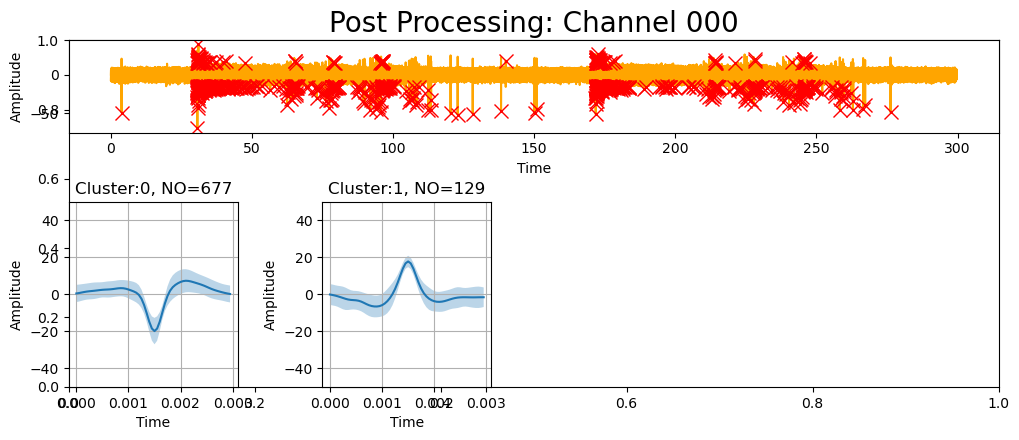

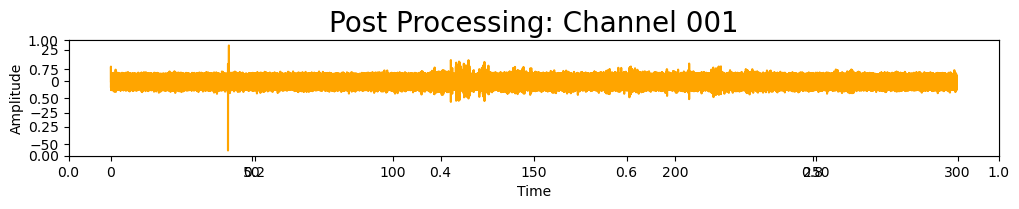

In [5]:
import csv
import math

# Initialize lists to store columns
RemovingChannels = []      # used to import the first column
KeeporNot = []             # used to import the second column
RemovingClusters = []      # used to import the other columns

# Open and read the CSV file
with open(Export_FolderName + '/RemovingArtifacts.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    for row in reader:
        if len(row) > 0:
            RemovingChannels.append(row[0])
        if len(row) > 1:
            KeeporNot.append(row[1])
        if len(row) > 2:
            RemovingClusters.append(row[2:])

def safe_int_conversion(value):
    try:
        return int(value)
    except ValueError:
        return None

RemovingChannels = [int(x) for x in RemovingChannels]  
KeeporNot = [int(x) for x in KeeporNot]  
for i in range(len(RemovingChannels)):
    RemovingClusters[i] = [safe_int_conversion(x) for x in RemovingClusters[i] if safe_int_conversion(x) is not None]  

for i in range(len(RemovingChannels)):
    channel = RemovingChannels[i]
    for j in range(len(RemovingClusters[i])):
        cluster = RemovingClusters[i][j]
        
        key = all_peak_datapoint[channel]
        key = [key[p] for p in range(len(key)) if all_clusters[channel][p] != cluster]
        all_peak_datapoint[channel] = key
            
        key = all_peak_positions[channel]
        key = [key[p] for p in range(len(key)) if all_clusters[channel][p] != cluster]
        all_peak_positions[channel] = key
            
        key = all_peak_segments[channel]
        key = [key[p] for p in range(len(key)) if all_clusters[channel][p] != cluster]
        all_peak_segments[channel] = key
            
        all_units = [unit for unit in all_units if not (unit['channel'] == channel and unit['cluster_number'] == cluster)]
            
        all_clusters[channel] = [x for x in all_clusters[channel] if x != cluster]
        
# ------------------------for ploting waveforms ---------------------------------------


for i in range(total_channel):
    
    units = [unit for unit in all_units if unit['channel'] == i ]
    clusters = all_clusters[i]
    
    figure_col = 4
    figure_row = 1 + math.ceil(len(units)/4)
    
    width_ratios = [1] * figure_col
    height_ratios = [1] * figure_row
    
    height_ratios[0] = 0.5 
    
    fig = plt.figure(figsize=(figure_col * 3, (figure_row - (1-height_ratios[0])) * 3))
    gs = gridspec.GridSpec(figure_row, figure_col, width_ratios=width_ratios, height_ratios=height_ratios)
    gs.update(wspace=0.5, hspace=0.5)  # Adjust as needed
    
    plt.title('Post Processing: Channel %03d' % i, fontsize=20) 
    
    subplot = fig.add_subplot(gs[0:1, 0:4])
    plt.plot(t, all_filtered_data[i], label='Channel%03d' % i, color='orange')
    plt.plot(t[all_peak_datapoint[i]], all_filtered_data[i][all_peak_datapoint[i]], 'x', color='red', markersize=10)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    voltage_limit_plus = 50
    voltage_limit_minus = - 50
    
    for k in range(len(units)):
        mean = units[k]['cluster_mean']
        std = units[k]['cluster_std']
        cluster = units[k]['cluster_number']
        y1 = math.ceil((k + 1) / 4)
        y2 = y1 + 1
        x1 = k - int((k + 1) / 4 - 0.1) * 4
        x2 = x1 + 1
        subplot = fig.add_subplot(gs[y1:y2, x1:x2])
        plt.plot(time, mean)
        plt.fill_between(time, mean - std, mean + std, alpha=0.3)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Cluster:%d, NO=%d' %(cluster, np.sum(all_clusters[i] == cluster)), fontsize=12, color='black')
        plt.ylim(voltage_limit_minus, voltage_limit_plus)
        plt.grid(True)
    
    plt.show()